In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [4]:
all_data = fls.load_all_train_data()
np.random.default_rng(seed=0).shuffle(all_data)

# Pick N tomograms with 1 motor and N tomograms with 0 motors as validation set
N=100
n_motors = np.array([len(d.labels) for d in all_data])
inds_zero = np.argwhere(n_motors==0)[:N,0]
inds_one = np.argwhere(n_motors==1)[:N,0]
inds_test = np.concatenate((inds_zero,inds_one))
inds_train = np.setdiff1d(np.arange(len(n_motors)), inds_test)
inds_test.shape, inds_train.shape

train_data = []
for i in inds_train:
    train_data.append(all_data[i])
test_data = []
for i in inds_test:
    test_data.append(all_data[i])
np.random.default_rng(seed=0).shuffle(test_data)
len(train_data), len(test_data)

(444, 200)

0
0.6760968208312989 0.9861917495727539
1
0.7029627323150635 0.982267951965332
2
0.7371617317199707 0.98165864944458
3
0.7351917266845703 0.9814502716064453
4
0.7319197654724121 0.9829012870788574
5
0.7535781860351562 0.9821366310119629
6
0.7838194847106934 0.976969051361084
7
0.7767224788665772 0.9737455368041992
8
0.7842826843261719 0.9776663780212402
9
0.7809641838073731 0.9800392150878906
10
0.7737740993499755 0.9715620040893554
11
0.7668371677398682 0.9672150611877441
12
0.7601814270019531 0.9755764007568359
13
0.7407080173492432 0.9715711593627929
14
0.7361562728881836 0.9764840126037597
15
0.7362083435058594 0.9711873054504394
16
0.7225804328918457 0.9698576927185059
17
0.7058118343353271 0.9676333427429199
18
0.7435072422027588 0.977663516998291
19
0.743242597579956 0.9735340118408203
20
0.7238029479980469 0.9709999084472656
21
0.7094456672668457 0.9652597427368164
22
0.7056115150451661 0.9636181831359864
23
0.7198598384857178 0.9659252166748047
24
0.7171998500823975 0.96539516

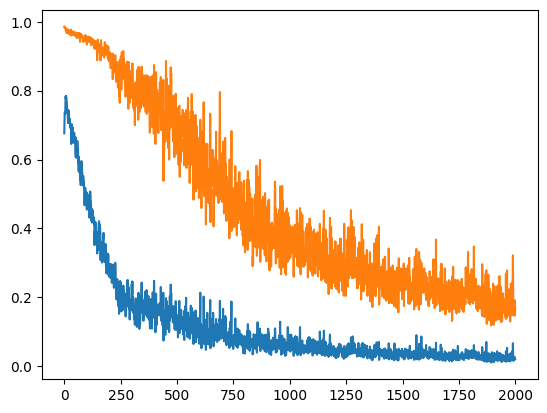

In [3]:
%%time
model = flg_model.ThreeStepModel()
model.step1Heatmap.n_epochs = 2000
model.train(train_data)
plt.figure()
plt.plot(model.step1Heatmap.train_loss_list1)
plt.plot(model.step1Heatmap.train_loss_list2)
fls.dill_save(fls.temp_dir + 'model_temp.pickle', model)

In [3]:
model = fls.dill_load(fls.temp_dir + 'model_temp.pickle')
inferred_test_data = model.infer(test_data);
inferred_train_data = model.infer(train_data);
# for inf,test in zip(inferred_test_data, this_test_data):
#     print('')
#     print('')
#     print(test.name)
#     print(test.labels)
#     print(inf.labels)

torch.Size([300, 959, 928])
     z    y    x   size  max_logit
0  112  813  678  94257      51.75
torch.Size([500, 924, 956])
Empty DataFrame
Columns: [z, y, x, size, max_logit]
Index: []
torch.Size([300, 960, 928])
Empty DataFrame
Columns: [z, y, x, size, max_logit]
Index: []
torch.Size([300, 960, 928])
     z    y    x   size  max_logit
1  120  235  656  90256       41.0
torch.Size([800, 928, 928])
Empty DataFrame
Columns: [z, y, x, size, max_logit]
Index: []
torch.Size([300, 960, 928])
     z    y    x   size  max_logit
0  134  324  750  73885   40.53125
torch.Size([300, 960, 928])
Empty DataFrame
Columns: [z, y, x, size, max_logit]
Index: []
torch.Size([300, 960, 928])
Empty DataFrame
Columns: [z, y, x, size, max_logit]
Index: []
torch.Size([300, 928, 928])
     z    y    x    size  max_logit
0  151  765  662  129231    107.625
torch.Size([300, 928, 928])
    z    y    x   size  max_logit
1  87  344  566  64979   21.78125
torch.Size([500, 924, 956])
Empty DataFrame
Columns: [z, y, 

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.58 GiB. GPU 0 has a total capacity of 11.99 GiB of which 4.13 GiB is free. Of the allocated memory 3.32 GiB is allocated by PyTorch, and 3.29 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
fls.dill_save(fls.temp_dir + 'res.pickle', (inferred_test_data, test_data, inferred_train_data, train_data))

NameError: name 'inferred_test_data' is not defined

In [5]:
importlib.reload(fls)
inferred_test_data, test_data, inferred_train_data, train_data = fls.dill_load(fls.temp_dir + 'res.pickle')

In [6]:
import sklearn
import pandas as pd

def distance_metric(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    thresh_ratio: float,
    min_radius: float,
):
    coordinate_cols = ['Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    label_tensor = solution[coordinate_cols].values.reshape(len(solution), -1, len(coordinate_cols))
    predicted_tensor = submission[coordinate_cols].values.reshape(len(submission), -1, len(coordinate_cols))
    # Find the minimum euclidean distances between the true and predicted points
    solution['distance'] = np.linalg.norm(label_tensor - predicted_tensor, axis=2).min(axis=1)
    # Convert thresholds from angstroms to voxels
    solution['thresholds'] = solution['Voxel spacing'].apply(lambda x: (min_radius * thresh_ratio) / x)
    solution['predictions'] = submission['Has motor'].values
    solution.loc[(solution['distance'] > solution['thresholds']) & (solution['Has motor'] == 1) & (submission['Has motor'] == 1), 'predictions'] = 0
    return solution['predictions'].values
    
def score(solution: pd.DataFrame, submission: pd.DataFrame, min_radius: float, beta: float) -> float:
    """
    Parameters:
    solution (pd.DataFrame): DataFrame containing ground truth motor positions.
    submission (pd.DataFrame): DataFrame containing predicted motor positions.

    Returns:
    float: FBeta score.

    Example
    --------
    >>> solution = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [-1, 250, 100, 200],
    ...     'Motor axis 1': [-1, 250, 100, 200],
    ...     'Motor axis 2': [-1, 250, 100, 200],
    ...     'Voxel spacing': [10, 10, 10, 10],
    ...     'Has motor': [0, 1, 1, 1]
    ... })
    >>> submission = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [100, 251, 600, -1],
    ...     'Motor axis 1': [100, 251, 600, -1],
    ...     'Motor axis 2': [100, 251, 600, -1]
    ... })
    >>> score(solution, submission, 1000, 2)
    0.3571428571428571
    """

    solution = solution.sort_values('tomo_id').reset_index(drop=True)
    submission = submission.sort_values('tomo_id').reset_index(drop=True)

    filename_equiv_array = solution['tomo_id'].eq(submission['tomo_id'], fill_value=0).values

    if np.sum(filename_equiv_array) != len(solution['tomo_id']):
        raise ValueError('Submitted tomo_id values do not match the sample_submission file')

    submission['Has motor'] = 1
    # If any columns are missing an axis, it's marked with no motor
    select = (submission[['Motor axis 0', 'Motor axis 1', 'Motor axis 2']] == -1).any(axis='columns')
    submission.loc[select, 'Has motor'] = 0

    cols = ['Has motor', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    assert all(col in submission.columns for col in cols)

    # Calculate a label of 0 or 1 using the 'has motor', and 'motor axis' values
    predictions = distance_metric(
        solution,
        submission,
        thresh_ratio=1.0,
        min_radius=min_radius,
    )

    return sklearn.metrics.fbeta_score(solution['Has motor'].values, predictions, beta=beta)

In [18]:
row_df_sub = fls.create_submission_dataframe(inferred_test_data, reference_data = test_data)
row_df_ref = fls.create_submission_dataframe(test_data, reference_data = test_data, include_voxel_spacing=True)
print(score(row_df_ref, row_df_sub, 1000, 2))

0.5486542443064182


In [19]:
train_data_1_motor = []
inferred_train_data_1_motor = []
for i,t in zip(inferred_train_data, train_data):
    if len(t.labels)<=1:
        train_data_1_motor.append(t)
        inferred_train_data_1_motor.append(i)
    
row_df_sub = fls.create_submission_dataframe(inferred_train_data_1_motor, reference_data = train_data_1_motor)
row_df_ref = fls.create_submission_dataframe(train_data_1_motor, reference_data = train_data_1_motor, include_voxel_spacing=True)
print(score(row_df_ref, row_df_sub, 1000, 2))

0.9611829944547134


In [17]:
np.mean([len(d.labels) for d in test_data])

0.5

In [10]:
row_df_ref

,row_id,tomo_id,z,y,x,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors


In [21]:
inferred_test_data[0]

Data(is_train=True, name='tomo_0f9df0', labels=Empty DataFrame
Columns: [z, y, x, size, max_logit]
Index: [], loaded_state='unloaded', data=None, voxel_spacing=6.5, mean_per_slice=array([], dtype=float64), std_per_slice=array([], dtype=float64))